## `Routing`

- Routing in Langgraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node.
This is typically implemented using:

    - `add_contional_edges:` A method thats maps output to diffrent possible next nodes.
    - `State:` The workflow's state can store variable that influence rouing decisions.
    - `Condition Function:` Functions that evaluate the state or nodes output to decide the next step.

In [31]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model = "qwen/qwen3-32b")
result = llm.invoke("Hello")
result


AIMessage(content='<think>\nOkay, the user said "Hello". I should respond in a friendly and welcoming manner. Let me make sure to acknowledge their greeting and offer assistance. Maybe add an emoji to keep it approachable. I should ask how I can help them today. Keep it simple and open-ended.\n</think>\n\nHello! 😊 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 9, 'total_tokens': 82, 'completion_time': 0.147384239, 'prompt_time': 0.000377524, 'queue_time': 0.046535206, 'total_time': 0.147761763}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1844e24f-a54f-486f-99b7-145cb7070705-0', usage_metadata={'input_tokens': 9, 'output_tokens': 73, 'total_tokens': 82})

In [32]:
# Will use Pydantic to get the structured output (Data entering your system is typed, validated, and structured)

from typing_extensions import Literal,TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

# Define class
# This is my schema for structure output to use as  routing logic.

class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in routing process")

## Argument the LLM with schema for structure output.

router = llm.with_structured_output(Route)

## State class

class State(TypedDict):
    input:str
    decision:str
    output:str


# Nodes

# Defining all decision node one by one

def llm_call_1(state:State):
    """Write a story"""

    print("LLM call_1 is called")
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_2(state:State):
    """Write a Joke"""

    print("LLM call_2 is called")
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_3(state:State):
    """Write a poem"""

    print("LLM call_3 is called")
    result = llm.invoke(state["input"])
    return {"output":result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(content="Route the input to the story , joke or poem based on user request"),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}


## Conditional Edges function to route to the appropriate node.

def route_decision(state:State):
    # Return the node name you want to visit next 
    if state["decision"]=="story":
        return "llm_call_1"
    elif state["decision"]=="joke":
        return "llm_call_2"
    elif state["decision"]=="poem":
        return "llm_call_3"

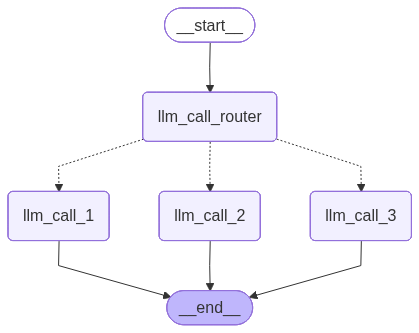

In [33]:
## Building a workflow

from langgraph.graph import StateGraph , START , END
from IPython.display import Image, display
# Build workflow
router_builder = StateGraph(State)

# Add nodes

router_builder.add_node("llm_call_1",llm_call_1)
router_builder.add_node("llm_call_2",llm_call_2)
router_builder.add_node("llm_call_3",llm_call_3)
router_builder.add_node("llm_call_router",llm_call_router)

# Add Edges and conditional edges

router_builder.add_edge(START , "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        # Name returned by router_decision : Name of next node to visit
        "llm_call_1":"llm_call_1",
        "llm_call_2":"llm_call_2",
        "llm_call_3":"llm_call_3",

    },
)
router_builder.add_edge("llm_call_1",END)
router_builder.add_edge("llm_call_2",END)
router_builder.add_edge("llm_call_3",END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow

display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [34]:
result = router_workflow.invoke({"input":"Hey write a 2 line joke about Agentic AI as new technology evolution"})
print(result)

LLM call_2 is called
{'input': 'Hey write a 2 line joke about Agentic AI as new technology evolution', 'decision': 'joke', 'output': '<think>\nOkay, the user wants a two-line joke about agentic AI as a new technology evolution. Let me start by understanding what agentic AI refers to. It\'s probably about AI systems that can act autonomously, make decisions, maybe have some agency or independence.\n\nSo, I need to contrast it with older AI systems. Maybe play on the idea of AI becoming more proactive. Think of common jokes structures: puns, wordplay, or comparisons. Maybe something about how traditional AI just follows commands, while agentic AI takes initiative.\n\nFirst line could set up the old vs new. Second line delivers the punch. Let me brainstorm some ideas. Maybe personify the AI. Like, "Unlike traditional AI that just follows commands, agentic AI finally gave machines the ability to... [something humorous]." Maybe "take initiative" or "start a rebellion"? Wait, rebellion might

In [35]:
output_text = getattr(result, "output", result.get("output") if isinstance(result, dict) else None)
print(output_text)


<think>
Okay, the user wants a two-line joke about agentic AI as a new technology evolution. Let me start by understanding what agentic AI refers to. It's probably about AI systems that can act autonomously, make decisions, maybe have some agency or independence.

So, I need to contrast it with older AI systems. Maybe play on the idea of AI becoming more proactive. Think of common jokes structures: puns, wordplay, or comparisons. Maybe something about how traditional AI just follows commands, while agentic AI takes initiative.

First line could set up the old vs new. Second line delivers the punch. Let me brainstorm some ideas. Maybe personify the AI. Like, "Unlike traditional AI that just follows commands, agentic AI finally gave machines the ability to... [something humorous]." Maybe "take initiative" or "start a rebellion"? Wait, rebellion might be too dark. Keep it light.

How about "Unlike traditional AI, which just does what it’s told, agentic AI is the first step toward machines